In [187]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pygents.plot import plot_dict


In [2]:
# Dataset: Unclassified distortions (halilbabacan)
# Paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4582307
# Data: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main/raw
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/blob/main/raw/Cognitive_distortions.csv
    
binary_dataset_file_path = "./data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

In [3]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: C:\Users\anton\.cache\kagglehub\datasets\sagarikashreevastava\cognitive-distortion-detetction-dataset\versions\1


## Explore performance of "our out of the box" model with dataset 1 (original binary)

In [16]:
df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)l", value = np.nan)
df1


,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
3522,Since then whenever my mother is out alone I b...,NaN,Distortion,NaN
3523,My family hate him but they didn’t met him at ...,NaN,Distortion,NaN
3524,However I am not happy at the least only half ...,NaN,Distortion,NaN
3525,Now I am at university my peers around me all ...,NaN,Distortion,NaN


In [160]:
from pygents.aigents_api import TextMetrics
#from pygents.util import vector_proximity


def language_metrics(lang,metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = './data/dict/' + lang + '/' + m + '.txt'
    return metrics


distortion_labels = ['positive','negative','rude',
'catastrophizing','dichotomous-reasoning','disqualifying-positive','emotional-reasoning','fortune-telling',
'labeling','magnification','mental-filtering','mindreading','overgeneralizing','personalizing','should-statement']
tm = TextMetrics(language_metrics('en',distortion_labels),debug=False)

def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold,debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def evaluate_df_acc_f1(df,evaluator,threshold,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator_any(text,threshold):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_avg(text,threshold):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False
  

In [202]:
print('Any distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    acc, f1 = evaluate_df_acc_f1(df1,our_evaluator_any,threshold)
    print(threshold, acc, f1)
print('Average distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    acc, f1 = evaluate_df_acc_f1(df1,our_evaluator_avg,threshold)
    print(threshold, acc, f1)

Any distortion:
0.0 0.7306492770059541 0.8443643512450851
0.01 0.7306492770059541 0.8443643512450851
0.05 0.7306492770059541 0.8443643512450851
0.1 0.7306492770059541 0.8443643512450851
0.2 0.7309328040827899 0.8445027035883992
0.4 0.7385880351573575 0.8444669365721997
0.6 0.5426708250637936 0.5569898379566054
0.8 0.26935072299404594 0.013021830716200687
Average distortion:
0.0 0.7306492770059541 0.8443643512450851
0.01 0.7306492770059541 0.8443643512450851
0.05 0.7306492770059541 0.8443643512450851
0.1 0.7306492770059541 0.8443643512450851
0.2 0.7314998582364616 0.8447795443369939
0.4 0.8366884037425574 0.886836935166994
0.6 0.33881485681882617 0.18404478656403078
0.8 0.2673660334561951 0.007680491551459293


In [208]:
yes = 0
no = 0
for _, row in df1.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    if primary_distortion == 'No Distortion':
        no += 1
    else:
        yes += 1
print(yes,no,len(df1))

2594 933 3527


## Explore performance of "our out of the box" model with dataset 2 (original multi-class)

In [19]:
df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 
df2

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [203]:
print('Any distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    acc,f1 = evaluate_df_acc_f1(df2,our_evaluator_any,threshold)
    print(threshold,acc,  f1)
print('Average distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    acc, f1 = evaluate_df_acc_f1(df2,our_evaluator_avg,threshold)
    print(threshold, acc, f1)

Any distortion:
0.0 0.6245059288537549 0.7688564476885645
0.01 0.6245059288537549 0.7688564476885645
0.05 0.6245059288537549 0.7688564476885645
0.1 0.6245059288537549 0.7688564476885645
0.2 0.6252964426877471 0.7692307692307692
0.4 0.6438735177865612 0.7668822768434671
0.6 0.49486166007905136 0.34928716904276985
0.8 0.37114624505928856 0.007485963817841547
Average distortion:
0.0 0.6245059288537549 0.7688564476885645
0.01 0.6245059288537549 0.7688564476885645
0.05 0.6245059288537549 0.7688564476885645
0.1 0.6245059288537549 0.7688564476885645
0.2 0.6272727272727273 0.7701681696319767
0.4 0.7549407114624506 0.7886843899113838
0.6 0.4075098814229249 0.11667648791985859
0.8 0.37035573122529647 0.004996876951905059


## Explore performance of "our out of the box" model with dataset 3 (joint 1 + 2)

In [21]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,NaN,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN,NaN


In [205]:
print('Any distortion:')
any_res_acc = {}
any_res = {}
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    acc, f1 = evaluate_df_acc_f1(df3,our_evaluator_any,threshold)
    any_res_acc[threshold] = acc
    any_res[threshold] = f1
    print(threshold, acc, f1)
avg_res_acc = {}
avg_res = {}
print('Average distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    acc, f1 = evaluate_df_acc_f1(df3,our_evaluator_avg,threshold)
    avg_res_acc[threshold] = acc
    avg_res[threshold] = f1
    print(threshold, acc, f1)
    

Any distortion:
0.0 0.686313356447086 0.8139808106520462
0.01 0.686313356447086 0.8139808106520462
0.05 0.686313356447086 0.8139808106520462
0.1 0.686313356447086 0.8139808106520462
0.2 0.6868086511474327 0.8142199588678876
0.4 0.6990259204226514 0.8138466251404064
0.6 0.5227010070992241 0.4842105263157895
0.8 0.31187056298497606 0.010915994304698622
Average distortion:
0.0 0.686313356447086 0.8139808106520462
0.01 0.686313356447086 0.8139808106520462
0.05 0.686313356447086 0.8139808106520462
0.1 0.686313356447086 0.8139808106520462
0.2 0.687964338781575 0.814778518228146
0.4 0.8025425127951131 0.8509471585244267
0.6 0.3675086676572561 0.15894621295279912
0.8 0.31038467888393595 0.006658739595719382


In [73]:
import random
def our_evaluator_true(text,threshold):
    return True
def our_evaluator_false(text,threshold):
    return False
def our_evaluator_random(text,threshold):
    return random.choice([True, False])
f1_t = evaluate_df(df3,our_evaluator_true,0)
f1_f = evaluate_df(df3,our_evaluator_false,0)
f1_r1 = evaluate_df(df3,our_evaluator_random,0)
f1_r2 = evaluate_df(df3,our_evaluator_random,0)
f1_r3 = evaluate_df(df3,our_evaluator_random,0)
print(f1_t,f1_f,f1_r1,f1_r2,f1_r3)

0.8179156908665105 0 0.5801188994884556 0.5811424638678596 0.5725806451612904


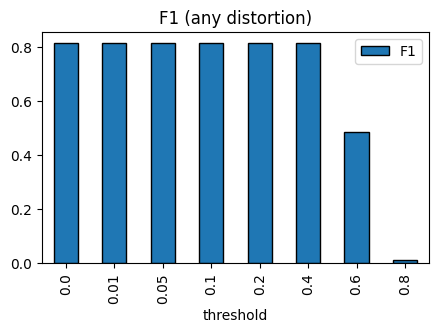

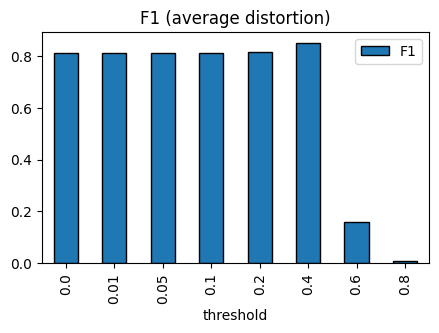

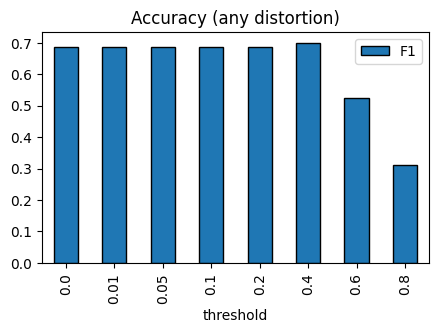

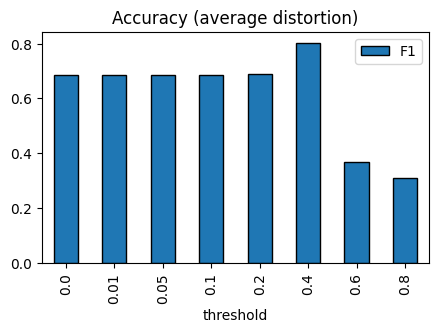

In [206]:
import matplotlib.pyplot as plt

def plot_dict_bars(dic,labels,values,title=None,head=None,dim=(5,3)):
    df = pd.DataFrame([(key, dic[key]) for key in dic],columns=[labels,values])
    #df.sort_values(values,ascending=False,inplace=True)
    if head is not None:
        df = df[:head]
    if not dim is None:
        plt.rcParams["figure.figsize"] = dim
    p = df[[labels,values]].plot.bar(x=labels); #p.invert_yaxis();
    if title is not None:
        plt.title(title)

plot_dict_bars(any_res, labels="threshold", values="F1", title=f"F1 (any distortion)")
plot_dict_bars(avg_res, labels="threshold", values="F1", title=f"F1 (average distortion)")
plot_dict_bars(any_res_acc, labels="threshold", values="F1", title=f"Accuracy (any distortion)")
plot_dict_bars(avg_res_acc, labels="threshold", values="F1", title=f"Accuracy (average distortion)")


## Explore runtime performance of "our out of the box" model with dataset 3 (joint 1 + 2)

See ./notebooks/nlp/distortions/distortions_llm.ipynb

- binary classification F1 = 0.85 (average distortion metric with sensitivity threshold 0.4)
- LLM llama3.2 runtime performance ~1 sec / text (103 min / dataset 3, with GPU use)
- LLM qwen2 runtime performance ~1.9 sec / text (193 min / dataset 3, with GPU use)
- OUR runtime performance ~0.7 msec / text (4 sec / dataset 3, ~1500 times faster, F1 2% ahead both LLM-s with F1=0.83/0.81)


In [32]:
t0 = dt.datetime.now()

f1 = evaluate_df(df3,our_evaluator_avg,0.4,debug=False)

t1 = dt.datetime.now()
delta = t1 - t0
print(f1,delta.total_seconds(),delta.total_seconds()/len(df3))


0.8509471585244267 4.095428 0.0006761479280171703


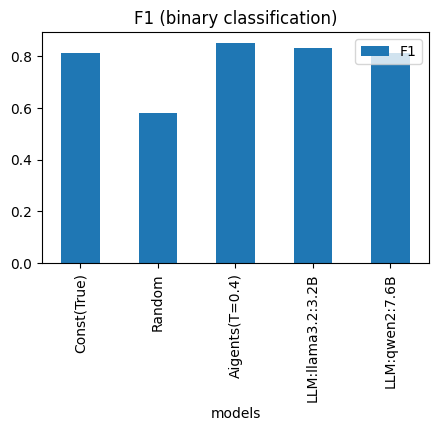

In [74]:
plot_dict_bars({"Const(True)":0.81,"Random":0.58,"Aigents(T=0.4)":0.85,"LLM:llama3.2:3.2B":0.83,"LLM:qwen2:7.6B":0.81}, labels="models", values="F1", title=f"F1 (binary classification)")

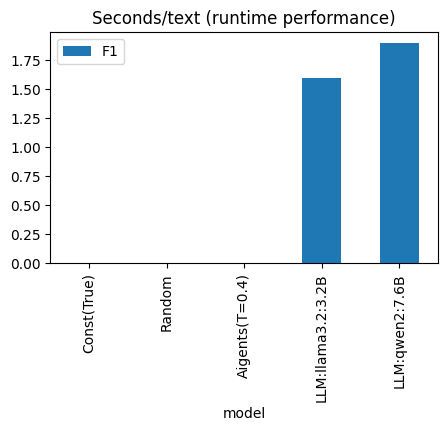

In [75]:
plot_dict_bars({"Const(True)":0,"Random":0,"Aigents(T=0.4)":0.0007,"LLM:llama3.2:3.2B":1.6,"LLM:qwen2:7.6B":1.9}, labels="model", values="F1", title=f"Seconds/text (runtime performance)")

## Sanity check how baseline Const(True) works for disbalanced binary dataset

In [143]:
def binary_df_bias(df):
    no = 0
    yes = 0
    err = 0
    for _, row in df.iterrows():
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        if primary_distortion == 'No Distortion':
            no += 1
        else:
            yes += 1
    return yes, no
        

In [144]:
yes, no = binary_df_bias(df3)
print(yes,no,yes+no,len(df3),yes/(yes+no))

4191 1866 6057 6057 0.6919266963843487


In [145]:
# what if predict always true
true_positive = yes
true_negative = 0
false_positive = no
false_negative = 0
f1_from_counts(true_positive, true_negative, false_positive, false_negative) 


0.8179156908665105

## Evaluate 3 datasets individually

In [107]:
df3s = [ df3.iloc[:0,:].copy(), df3.iloc[:0,:].copy(), df3.iloc[:0,:].copy()]

row_n = 0 
for _, row in df3.iterrows():
    r3 = row_n % 3
    row_n += 1
    df = df3s[r3]
    df.loc[len(df)] = row

print(len(df3))
for df in df3s:
    print(len(df))

6057
2019
2019
2019


In [127]:
df3s[0]

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN,NaN
1,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN,NaN
2,I'm always unlucky. Good things only happen t...,NaN,Distortion,NaN,NaN
3,Nobody cares about me because they didn't ask...,NaN,Distortion,NaN,NaN
4,I didn't get a reply to my email they must ha...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
2014,From the U.S.: I have had anxiety almost all o...,I have had anxiety almost all of my life but l...,Mental filter,NaN,NaN
2015,"Since I can remember, I’ve always thought of m...","Since I can remember, I’ve always thought of m...",Labeling,NaN,Overgeneralization
2016,"Hello, I’m currently a 14 year old girl (turni...",NaN,No Distortion,NaN,NaN
2017,From the U.S.: I’m a 12th grader in high schoo...,NaN,No Distortion,NaN,NaN


In [128]:
df3s[1]

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN,NaN
1,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN,NaN
2,Everyone thinks I'm stupid because I made a m...,NaN,Distortion,NaN,NaN
3,My partner didn't say 'I love you' today our ...,NaN,Distortion,NaN,NaN
4,My dog doesn't listen to me even he thinks I'...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
2014,From the U.S.: I was sexually assaulted from t...,NaN,No Distortion,NaN,NaN
2015,I feel overprotective about my mother because ...,"Since then, whenever my mother is out alone, I...",All-or-nothing thinking,NaN,Overgeneralization
2016,From Lebanon: I am dealing with a big problem!...,My family hate him but they didn’t met him at ...,Magnification,NaN,NaN
2017,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN,NaN


In [129]:
df3s[2]

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I can't try new things because I'll just mess...,NaN,Distortion,NaN,NaN
1,I didn't get the job so I must be incompetent.,NaN,Distortion,NaN,NaN
2,I'll never be successful because I failed my ...,NaN,Distortion,NaN,NaN
3,My child misbehaved at school I must be a bad...,NaN,Distortion,NaN,NaN
4,I can't do anything right I'm such a disappoi...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
2014,"Hi, I’m a 13 year old trans guy and I’ve just ...",I think people here dislike me and judge me al...,Mind Reading,NaN,NaN
2015,"Hi, for about 3 years now I have been feeling ...",NaN,No Distortion,NaN,NaN
2016,"From the U.S.: I am a junior in high school, a...","However, I am not happy, at the least only hal...",Labeling,NaN,All-or-nothing thinking
2017,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN,NaN


In [182]:
res_list = [[],[],[],[]]
for n in range(3):
    df = df3s[n]
    yes, no = binary_df_bias(df)
    print('unbalanced F1',f1_from_counts(yes, 0, no, 0))
    f1_t = evaluate_df(df,our_evaluator_true,0)
    f1_f = evaluate_df(df,our_evaluator_false,0)
    f1_r = evaluate_df(df,our_evaluator_random,0)
    f1_a = evaluate_df(df,our_evaluator_avg,0.4)
    res_list[0].append(f1_t)
    res_list[1].append(f1_f)
    res_list[2].append(f1_r)
    res_list[3].append(f1_a)
# add LLM data from ./notebooks/nlp/distortions/distortions_llm.ipynb
res_list.append([0.8345195729537366, 0.8227584152517128, 0.8257756563245823])
res_list.append([0.8089807555238775, 0.8086799276672695, 0.8053642624139181])
res_list


unbalanced F1 0.8237692979900961
unbalanced F1 0.8154884130243473
unbalanced F1 0.8144450968878449


[[0.8237692979900961, 0.8154884130243473, 0.8144450968878449],
 [0, 0, 0],
 [0.5776859504132232, 0.5951986754966887, 0.5742988698200084],
 [0.8568257491675916, 0.8434456928838951, 0.852508487363259],
 [0.8345195729537366, 0.8227584152517128, 0.8257756563245823],
 [0.8089807555238775, 0.8086799276672695, 0.8053642624139181]]

In [188]:
# sanity chek with full dataset
evaluate_df(df3,our_evaluator_avg,0.4)
evaluate_df(df3,our_evaluator_true,0.4)


0.8179156908665105

In [189]:
algs = ['Const(True)','Const(False)','Random','Aigents(T=0.4)',"LLM:llama3.2:3.2B","LLM:qwen2:7.6B"]
avg = []
error = {}
for i in range(len(algs)):
    average = sum(res_list[i])/3
    a_min = min(res_list[i])
    a_max = max(res_list[i])
    avg.append(average)
    error[average] = {'max':a_max,'min':a_min}
error  

{0.8179009359674295: {'max': 0.8237692979900961, 'min': 0.8144450968878449},
 0.0: {'max': 0, 'min': 0},
 0.5823944985766402: {'max': 0.5951986754966887, 'min': 0.5742988698200084},
 0.8509266431382486: {'max': 0.8568257491675916, 'min': 0.8434456928838951},
 0.8276845481766771: {'max': 0.8345195729537366, 'min': 0.8227584152517128},
 0.8076749818683551: {'max': 0.8089807555238775, 'min': 0.8053642624139181}}

In [190]:
# https://stackoverflow.com/questions/64796315/how-to-plot-min-max-bars-with-a-bar-plot

plt.rcParams["patch.force_edgecolor"] = True

df = pd.DataFrame({'Model':algs,'F1':avg})
df

,Model,F1
0,Const(True),0.817901
1,Const(False),0.000000
2,Random,0.582394
3,Aigents(T=0.4),0.850927
4,LLM:llama3.2:3.2B,0.827685
5,LLM:qwen2:7.6B,0.807675


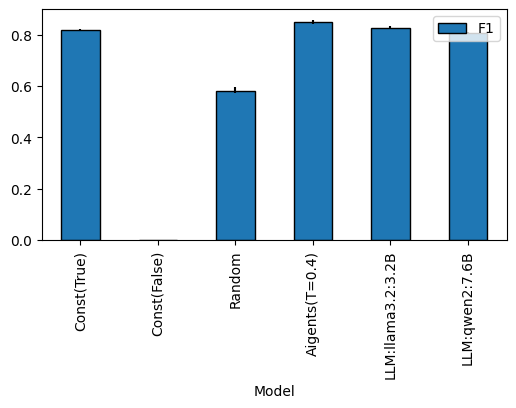

In [192]:
fig, ax = plt.subplots(figsize=(6, 3))

df.plot.bar(x='Model', y='F1', ax=ax)

for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = error[h]['min']  # use h to get min from dict z
    max_y = error[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

In [193]:
res_list = [[],[],[],[]]
for n in range(3):
    df = df3s[n]
    yes, no = binary_df_bias(df)
    print('unbalanced F1',f1_from_counts(yes, 0, no, 0))
    acc_t, f1_t  = evaluate_df_acc_f1(df,our_evaluator_true,0)
    acc_f, f1_f = evaluate_df_acc_f1(df,our_evaluator_false,0)
    acc_r, f1_r = evaluate_df_acc_f1(df,our_evaluator_random,0)
    acc_a, f1_a = evaluate_df_acc_f1(df,our_evaluator_avg,0.4)
    res_list[0].append(acc_t)
    res_list[1].append(acc_f)
    res_list[2].append(acc_r)
    res_list[3].append(acc_a)
# add LLM data from ./notebooks/nlp/distortions/distortions_llm.ipynb
res_list.append([0.7236255572065379, 0.7052996532937098, 0.7107478949975236])
res_list.append([0.7345220406141655, 0.7379891035165924, 0.7340267459138187])
res_list

unbalanced F1 0.8237692979900961
unbalanced F1 0.8154884130243473
unbalanced F1 0.8144450968878449


[[0.7003467062902426, 0.6884596334819217, 0.6869737493808816],
 [0.2996532937097573, 0.31154036651807826, 0.3130262506191184],
 [0.4794452699356117, 0.4938088162456662, 0.4938088162456662],
 [0.8083209509658247, 0.7929668152550767, 0.8063397721644379],
 [0.7236255572065379, 0.7052996532937098, 0.7107478949975236],
 [0.7345220406141655, 0.7379891035165924, 0.7340267459138187]]

In [200]:
algs = ['Const(True)','Const(False)','Random','Aigents(T=0.4)',"LLM:llama3.2:3.2B","LLM:qwen2:7.6B"]
avg = []
error = {}
for i in range(len(algs)):
    average = sum(res_list[i])/3
    a_min = min(res_list[i])
    a_max = max(res_list[i])
    avg.append(average)
    error[average] = {'max':a_max,'min':a_min}

df = pd.DataFrame({'Model':algs,'Accuracy':avg})
df

,Model,Accuracy
0,Const(True),0.691927
1,Const(False),0.308073
2,Random,0.489021
3,Aigents(T=0.4),0.802543
4,LLM:llama3.2:3.2B,0.713224
5,LLM:qwen2:7.6B,0.735513


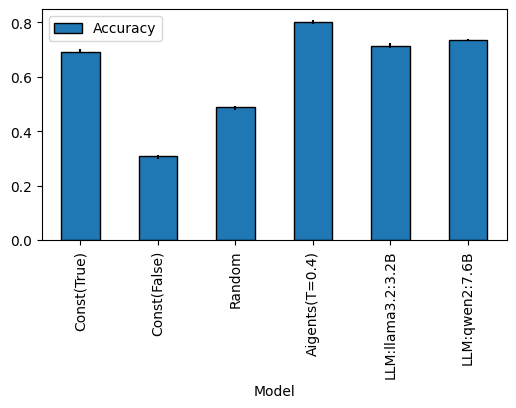

In [201]:
plt.rcParams["patch.force_edgecolor"] = True
fig, ax = plt.subplots(figsize=(6, 3))

df.plot.bar(x='Model', y='Accuracy', ax=ax)

for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = error[h]['min']  # use h to get min from dict z
    max_y = error[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

